In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

./Project_1.ipynb
./.ipynb_checkpoints/Project_1-checkpoint.ipynb
./data/titanic.csv
./data/.ipynb_checkpoints/titanic-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

### This project is to predict how likely each passenger aboard the Titanic was to survive the sinking of the vessel, based on the variables given in the passenger database.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [2]:
OG_DF = pd.read_csv('./data/titanic.csv') # load csv as dataframe

OG_DF.head(7) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

### to-do: VISUALIZE THE FOLLOWING
* histogram of ages stratified by gender
* number of survivors stratified by age and gender
* relationship of sibsp/parch to survival
* fare price vs pclass + survival rates compared to this too

In [3]:
# print the number of nan values in each column
for col_name in OG_DF:
    print(f'Number of NaN values in {col_name} column: {OG_DF[col_name].isnull().sum()}')

Number of NaN values in PassengerId column: 0
Number of NaN values in Survived column: 0
Number of NaN values in Pclass column: 0
Number of NaN values in Name column: 0
Number of NaN values in Sex column: 0
Number of NaN values in Age column: 177
Number of NaN values in SibSp column: 0
Number of NaN values in Parch column: 0
Number of NaN values in Ticket column: 0
Number of NaN values in Fare column: 0
Number of NaN values in Cabin column: 687
Number of NaN values in Embarked column: 2


In [4]:
# create new df that can be modified  
df = OG_DF.copy() 

# remove all rows that have an age value of NaN
df.dropna(axis=0, subset=['Age'], inplace=True)

print(f'Number of NaN values in age column in modified dataframe: {df["Age"].isnull().sum()}')

Number of NaN values in age column in modified dataframe: 0


Text(0.5, 1.0, 'Number of Survivors by Age Group')

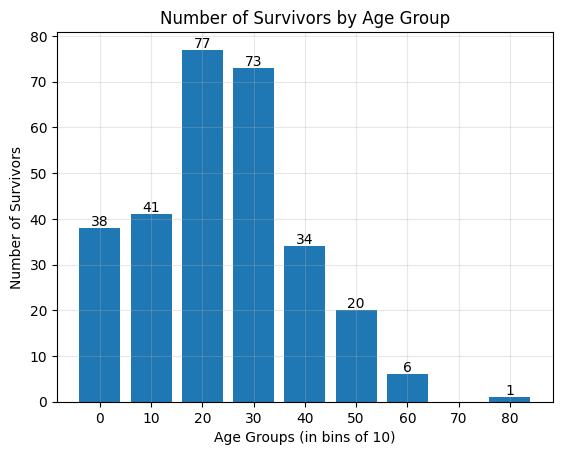

In [5]:
# show number of survivors by age group only via bar graph

survivors = df[df['Survived'] == 1]
age_groups = (survivors['Age'] // 10) * 10 
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]

svvs_by_age = age_groups.value_counts().sort_index()

plt.bar(svvs_by_age.index, svvs_by_age.values, width=8)

for x_coord, y_coord in svvs_by_age.items():
    plt.text(x_coord, y_coord+0.5, str(y_coord), ha='center', color='black')

plt.grid(True, alpha=0.3)
plt.xlabel('Age Groups (in bins of 10)')
plt.xticks(age_bins)
plt.ylabel('Number of Survivors')
plt.title('Number of Survivors by Age Group')

Text(0, 0.5, 'Number of Survivors')

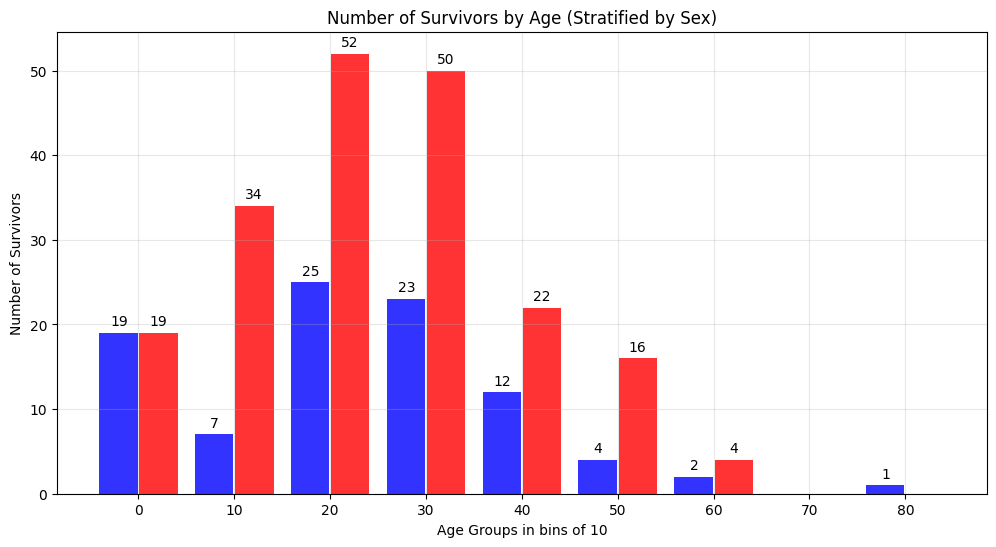

In [6]:
# show number of survivors by age group, but this time, indicate differences between gender

m_by_age = (((survivors[survivors['Sex'] == 'male'])['Age'] // 10) * 10).value_counts().sort_index() 
f_by_age = (((survivors[survivors['Sex'] == 'female'])['Age'] // 10) * 10).value_counts().sort_index() 

width = 4
spacing = 0.1

plt.figure(figsize=(12, 6))


plt.bar([i - width/2 - spacing for i in age_bins], [m_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.8, color='blue')
plt.bar([i + width/2 + spacing for i in age_bins], [f_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.8, color='red')

for i, age in enumerate(age_bins):
    m_count = m_by_age.get(age, 0)
    f_count = f_by_age.get(age, 0)

    if m_count > 0:
        plt.text(age - width/2 - spacing/2, m_count + 0.5, str(m_count),ha='center', va='bottom', color='black')

    if f_count > 0:
        plt.text(age + width/2 + spacing/2, f_count + 0.5, str(f_count),ha='center', va='bottom', color='black')

plt.grid(True, alpha=0.3)
plt.title('Number of Survivors by Age (Stratified by Sex)')
plt.xlabel('Age Groups in bins of 10')
plt.xticks(age_bins)
plt.ylabel('Number of Survivors')

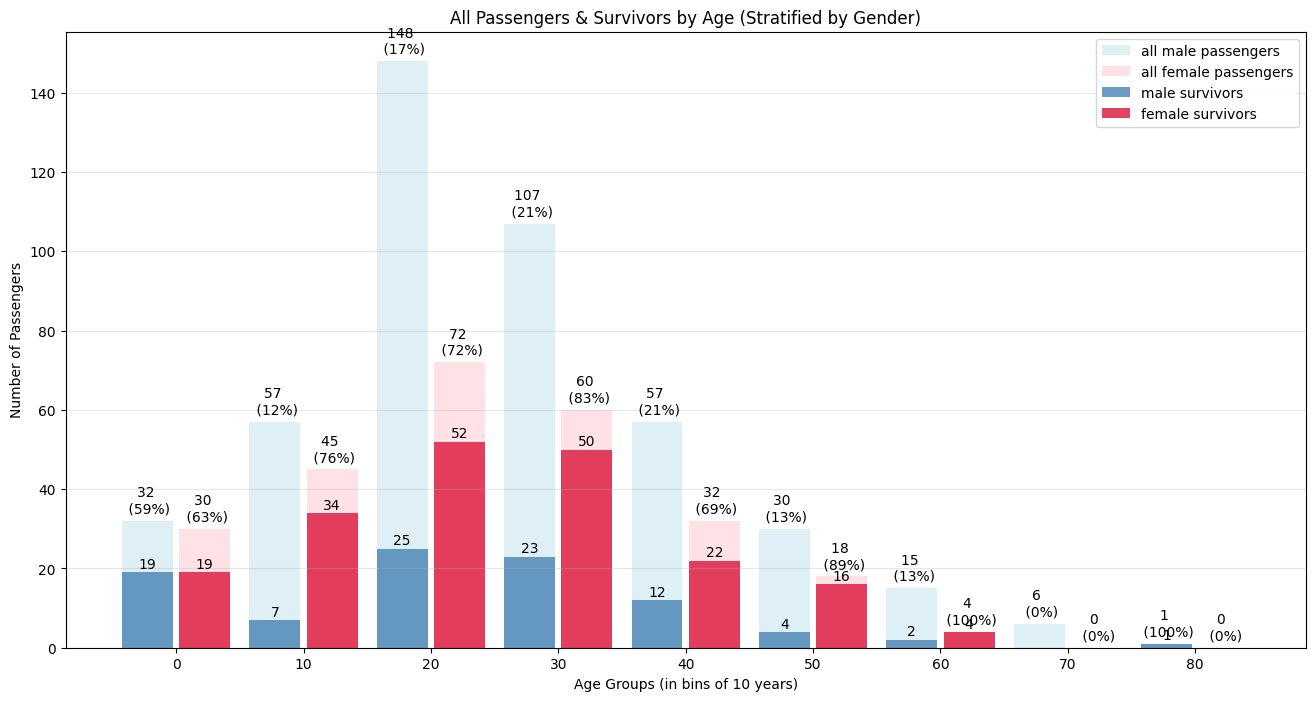

In [7]:
# show all passengers and the number of those passengers who survived, separated by gender and age 

# adjust as needed!
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
width = 4
spacing = 0.5

# extract dataframes for each category 
m_all = df[df['Sex'] == 'male'] 
f_all = df[df['Sex'] == 'female']

m_survivors = df[(df['Sex'] == 'male') & (df['Survived'] == 1)]
f_survivors = df[(df['Sex'] == 'female') & (df['Survived'] == 1)]

m_all_by_age = ((m_all['Age'] // 10) * 10).value_counts().sort_index()
f_all_by_age = ((f_all['Age'] // 10) * 10).value_counts().sort_index()

m_svvs_by_age = ((m_survivors['Age'] // 10) * 10).value_counts().sort_index()
f_svvs_by_age = ((f_survivors['Age'] // 10) * 10).value_counts().sort_index()


plt.figure(figsize=(16, 8))

plt.bar([i - width/2 - spacing/2 for i in age_bins], 
        [m_all_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.4, color='lightblue', label='all male passengers')

plt.bar([i + width/2 + spacing/2 for i in age_bins], 
        [f_all_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.4, color='lightpink', label='all female passengers')

plt.bar([i - width/2 - spacing/2 for i in age_bins], 
        [m_svvs_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.8, color='steelblue', label='male survivors')

plt.bar([i + width/2 + spacing/2 for i in age_bins], 
        [f_svvs_by_age.get(i, 0) for i in age_bins], 
        width=width, alpha=0.8, color='crimson', label='female survivors')

for age in age_bins:
    m_all_count = m_all_by_age.get(age, 0)
    f_all_count = f_all_by_age.get(age, 0)

    m_survivors_count = m_svvs_by_age.get(age, 0)
    f_survivors_count = f_svvs_by_age.get(age, 0)

    m_surv_rate = round(m_survivors_count / m_all_count * 100) if m_all_count > 0 else 0
    f_surv_rate = round(f_survivors_count / f_all_count * 100) if f_all_count > 0 else 0

    plt.text(age - width/2 - spacing/2, m_all_count + 2, f'{m_all_count} \n ({m_surv_rate}%)',
             ha='center', color='black')
    if m_survivors_count > 0:
        plt.text(age - width/2 - spacing/2, m_survivors_count + 1, str(m_survivors_count),
                 ha='center', color='black')

    plt.text(age + width/2 + spacing/2, f_all_count + 2, f'{f_all_count} \n ({f_surv_rate}%)',
             ha='center', color='black')
    if f_survivors_count > 0:
        plt.text(age + width/2 + spacing/2, f_survivors_count + 1, str(f_survivors_count),
                 ha='center', color='black')
    

plt.xlabel('Age Groups (in bins of 10 years)')
plt.ylabel('Number of Passengers')
plt.title('All Passengers & Survivors by Age (Stratified by Gender)')
plt.xticks(age_bins)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why

# to do:
- drop all columns that arent gender class age and possibly sibsp/parch (investigate relationship more btwn sibsp/parch and survival rates)
    - drop the rows w/ nan values in these columns too 
- one-hot encode via pd.get_dummies and other stuff

In [24]:
print('all columns: ', end='')
for col in df:
    print(col, end=', ')

# drop rows from df

modded_df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=False)
modded_df.dropna(axis=0)
# print(modded_df.shape[0]) GIVES NUMBER OF ROWS (714)
modded_df.head(10)

# modded_df['FamMems'] = modded_df['SibSp'] + modded_df['Parch']
modded_df = pd.get_dummies(modded_df, drop_first=False, columns=['Sex',])
modded_df.head()

all columns: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, 

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,False,True
1,1,1,38.0,1,0,71.2833,True,False
2,1,3,26.0,0,0,7.9250,True,False
3,1,1,35.0,1,0,53.1000,True,False
4,0,3,35.0,0,0,8.0500,False,True


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [27]:
# random forest model 

X = modded_df.drop('Survived', axis=1)
y = modded_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10,
    min_samples_split=5
)

rf.fit(X_train, y_train)

y_preds = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
print(f'accuracy: {accuracy:.3f}') # first run: 81.9% accuracy! 

accuracy: 0.823


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [48]:
# fine tuning! 
import time

search_spaces = {
    'n_estimators': Integer(10, 500),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'max_samples': Categorical([0.7, 0.8, 0.9, None])
}

bayes_search = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces,
    n_iter=100,
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
)

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() 
print(f'best parameters: {grid_search.best_params_}')
print(f'best cross-val score: {grid_search.best_score_:.3f}')
print(f'time taken for grid search completion: {(end-start):.2f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best parameters: {'max_depth': 10, 'max_features': 'log2', 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 241}
best cross-val score: 0.834
time taken for grid search completion: 6.79


In [49]:
best_model = grid_search.best_estimator_
y_preds = best_model.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_preds):.3f}')

accuracy: 0.814


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [12]:
def infrence(prams):
    results = m.run(prams)
    return results 